In [1]:
!pip install sentence-transformers faiss-cpu open-clip-torch openai torchvision
# Install the Tesseract engine
!apt-get update
!apt-get install -y tesseract-ocr

# Install the Python wrapper
!pip install pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 831.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44

In [ ]:
import fitz  # PyMuPDF
import cv2
import numpy as np
import pytesseract
import os
import re
from PIL import Image

# Paths
PDF_PATH = "/content/drive/MyDrive/Major Project/Biology Chapters/jesc105.pdf"
OUTPUT_DIR = "/content/drive/MyDrive/Major Project/diagrams_filtered_2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 📌 Helper: Clean filename
def clean_caption(text, max_len=60):
    if not text:
        return "diagram"
    cleaned = re.sub(r'[^\w\s-]', '', text)  # remove punctuation
    cleaned = "_".join(cleaned.strip().split())
    return cleaned[:max_len] if cleaned else "diagram"

# 📌 Helper: Is it just text?
def is_text_only_region(cropped_image, text_threshold=0.25):
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    non_zero_pixels = cv2.countNonZero(thresh)
    ocr_text = pytesseract.image_to_string(cropped_image, config='--psm 6')
    num_chars = len(ocr_text.strip())
    if non_zero_pixels == 0:
        return True
    return num_chars / (non_zero_pixels + 1) > text_threshold

# ✅ MAIN FUNCTION
def extract_clean_diagrams(pdf_path, output_dir, dpi=300, min_area=25000):
    doc = fitz.open(pdf_path)
    all_diagrams = []
    diagram_count = 0

    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(dpi=dpi)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Preprocessing
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)

        # Morphological ops to merge broken diagram boxes
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
        closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for i, cnt in enumerate(contours):
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            if area < min_area or w < 80 or h < 80:
                continue

            # Crop with padding
            pad = 15
            x1 = max(x - pad, 0)
            y1 = max(y - pad, 0)
            x2 = min(x + w + pad, img_bgr.shape[1])
            y2 = min(y + h + pad, img_bgr.shape[0])
            cropped = img_bgr[y1:y2, x1:x2]

            # Skip if mostly text
            if is_text_only_region(cropped):
                continue

            # Get caption below (preferred) or above
            caption_below = img_bgr[y2:min(y2 + 70, img_bgr.shape[0]), x1:x2]
            caption_above = img_bgr[max(y1 - 70, 0):y1, x1:x2]
            text_below = pytesseract.image_to_string(caption_below, config='--psm 6').strip()
            text_above = pytesseract.image_to_string(caption_above, config='--psm 6').strip()

            best_caption = text_below if len(text_below) >= len(text_above) else text_above
            clean_name = clean_caption(best_caption)
            filename = f"page{page_num+1}_fig{i+1}_{clean_name}.png"
            filepath = os.path.join(output_dir, filename)

            cv2.imwrite(filepath, cropped)
            diagram_count += 1

            all_diagrams.append({
                "file": filepath,
                "page": page_num + 1,
                "caption": best_caption,
                "bbox": (x, y, w, h)
            })

            print(f"✅ Saved: {filename}")

    print(f"\n🎯 Extracted {diagram_count} diagrams.")
    return all_diagrams

# Run it
results = extract_clean_diagrams(PDF_PATH, OUTPUT_DIR)

# Preview top 5
for r in results[:5]:
    print(f"{r['file']} | Page: {r['page']} | Caption: {r['caption']}")

In [4]:
# store_embeddings.py

import os
import json
import faiss
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from torchvision import transforms
import open_clip

# Folders
DAM_FOLDER = "dam"
VECTOR_FOLDER = "vector_db"
os.makedirs(VECTOR_FOLDER, exist_ok=True)

# Models
text_model = SentenceTransformer("all-MiniLM-L6-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
tokenizer = open_clip.get_tokenizer("ViT-B-32")
clip_model = clip_model.to(device)

# FAISS Index
dim = 384 + 512  # 384 = MiniLM text, 512 = CLIP image
index = faiss.IndexFlatL2(dim)
metadata = []

# Read single text file
all_info_path = os.path.join(DAM_FOLDER, "all_info.txt")
if not os.path.exists(all_info_path):
    raise FileNotFoundError("all_info.txt not found in dam folder")

with open(all_info_path, "r") as f:
    all_content = f.read()

# Parse content by extracting paragraphs containing diagram names
def parse_content(content, diagram_name):
    paragraphs = content.split("\n\n")  # Split by double newline (paragraphs)
    relevant_text = "No info available for this diagram"

    # Look for the diagram name in each paragraph
    for para in paragraphs:
        if diagram_name.lower() in para.lower():
            relevant_text = para.strip()
            break  # Use the first matching paragraph

    return relevant_text

# Loop through images in dam folder
for file in os.listdir(DAM_FOLDER):
    if file.endswith(".png"):
        name = os.path.splitext(file)[0]  # e.g., "brain"
        img_path = os.path.join(DAM_FOLDER, file)

        # Get corresponding text from parsed info
        content = parse_content(all_content, name)

        # Text embedding
        text_embed = text_model.encode([content])[0]

        # Image embedding
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_embed = clip_model.encode_image(image).squeeze(0).cpu().numpy()

        # Combine embeddings
        combined = torch.tensor(text_embed.tolist() + image_embed.tolist()).unsqueeze(0).numpy()

        # Store in vector DB
        index.add(combined)

        metadata.append({
            "name": name,
            "image_path": img_path,
            "text_path": all_info_path,
            "text": content
        })

# Save index and metadata
faiss.write_index(index, os.path.join(VECTOR_FOLDER, "faiss.index"))
with open(os.path.join(VECTOR_FOLDER, "metadata.json"), "w") as f:
    json.dump(metadata, f)

print(f"✅ Stored {len(metadata)} diagram entries in vector DB.")

✅ Stored 49 diagram entries in vector DB.


In [5]:
## Util

import re

# Supported difficulty levels
SUPPORTED_DIFFICULTY = ["easy", "moderate", "hard"]

def parse_user_query(user_prompt):
    """
    Parses user prompt and returns topic, difficulty level, and number of questions.
    Defaults: difficulty = 'moderate', questions = 5
    """
    user_prompt_lower = user_prompt.lower()

    # Defaults
    topic = None
    difficulty = "moderate"
    num_questions = 5

    # 1. Extract difficulty
    for level in SUPPORTED_DIFFICULTY:
        if re.search(rf"\b{level}\b", user_prompt_lower):
            difficulty = level
            break

    # 2. Extract number of questions - more robust (e.g., "give me 7", "generate 10", "ask 3 questions")
    num_match = re.search(r'(\d+)\s+(questions|qs|question)', user_prompt_lower)
    if num_match:
        num_questions = int(num_match.group(1))
    else:
        # fallback to first number if it's present
        numbers = re.findall(r'\d+', user_prompt_lower)
        if numbers:
            num_questions = int(numbers[0])

    # 3. Extract topic using broader patterns
    topic_patterns = [
        r"(?:on|about|regarding|related to|from|based on)\s+([a-z\s]+?)(?:[\.\,\;\:\n]|and\b|with\b|that\b|which\b|to\b|for\b|$)",
        r"questions\s+(?:on|about|from)\s+([a-z\s]+?)(?:[\.\,\;\:\n]|and\b|with\b|that\b|which\b|to\b|for\b|$)"
    ]

    for pattern in topic_patterns:
        match = re.search(pattern, user_prompt_lower)
        if match:
            topic = match.group(1).strip()
            break

    # If still not found, use fallback
    if not topic:
        topic = "general science topic"

    return {
        "topic": topic,
        "difficulty": difficulty,
        "num_questions": num_questions
    }


In [ ]:
# generate_questions.py

import faiss
import json
import torch
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pytesseract  # OCR library
import random

# Config
VECTOR_FOLDER = "vector_db"
DAM_FOLDER = "dam"
client = OpenAI(api_key="YOUR_API_KEY")  # Replace with your key

# Load DB and metadata
index = faiss.read_index(os.path.join(VECTOR_FOLDER, "faiss.index"))
with open(os.path.join(VECTOR_FOLDER, "metadata.json")) as f:
    metadata = json.load(f)

# Load embedding model
text_model = SentenceTransformer("all-MiniLM-L6-v2")

# Image handling functions
def get_diagram_path(topic, metadata_entry):
    """Use the image_path from metadata instead of a hardcoded map."""
    image_path = metadata_entry.get('image_path', None)
    print(f"Metadata entry for topic '{topic}': {metadata_entry}")
    if image_path and os.path.exists(image_path):
        return image_path
    print(f"Image path {image_path} from metadata not found or invalid for topic '{topic}'.")
    return None

def mask_labels_on_image(image_path, topic):
    """Use OCR to detect and randomly mask labeled parts, then label them as 'a', 'b', etc."""
    if not os.path.exists(image_path):
        return None, []

    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", 36)
    except:
        font = ImageFont.load_default()

    ocr_data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    detected_parts = []
    for i, text in enumerate(ocr_data["text"]):
        text = text.lower().strip()
        if text and ocr_data["conf"][i] > 60:
            detected_parts.append({
                "text": text,
                "x": ocr_data["left"][i],
                "y": ocr_data["top"][i],
                "w": ocr_data["width"][i],
                "h": ocr_data["height"][i]
            })

    masked_parts = []
    if detected_parts:
        num_to_mask = min(2, len(detected_parts))
        parts_to_mask = random.sample(detected_parts, num_to_mask)
        for idx, part in enumerate(parts_to_mask):
            x, y, w, h = part["x"], part["y"], part["w"], part["h"]
            padding = 15
            draw.rectangle([x - padding, y - padding, x + w + padding, y + h + padding], fill="white")
            label = chr(97 + idx)
            text_x = x + (w - 20) // 2
            text_y = y + (h - 20) // 2
            draw.text((text_x, text_y), label, fill="black", font=font)
            masked_parts.append(part["text"])

    if not masked_parts:
        print("Warning: No recognizable labels detected to mask.")
        draw.rectangle([100, 100, 200, 150], fill="white")
        draw.text((130, 120), "a", fill="black", font=font)
        masked_parts.append("unknown part")

    masked_path = os.path.join(DAM_FOLDER, f"masked_{topic.replace(' ', '_')}.png")
    img.save(masked_path)
    return masked_path, masked_parts

def display_diagram(diagram_path):
    if diagram_path and os.path.exists(diagram_path):
        try:
            img = Image.open(diagram_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            return True
        except Exception as e:
            print(f"Error displaying diagram: {e}")
            return False
    print("Diagram not found or path invalid.")
    return False

# Query vector DB with name filter
def get_info_from_query(query: str):
    embed = text_model.encode([query])[0]
    padded = np.pad(embed, (0, 512), mode='constant')
    D, I = index.search(np.array([padded]).astype('float32'), k=1)
    selected_entry = metadata[I[0][0]]
    print(f"FAISS selected entry for query '{query}': {selected_entry}")
    # Filter by name to ensure exact match
    query_name = query.split()[-1].lower()  # e.g., "human brain" -> "brain"
    if selected_entry['name'].lower() != query_name:
        print(f"Warning: FAISS selected '{selected_entry['name']}' but expected '{query_name}'. Searching metadata for exact match.")
        for entry in metadata:
            if entry['name'].lower() == query_name:
                print(f"Found exact match in metadata: {entry}")
                return entry
        print(f"No exact match found for '{query_name}' in metadata.")
        return None
    return selected_entry

def generate_questions(topic: str, num_q: str = '1', defficulty: str = "moderate", debug_ocr=False):
    # Get info from vector DB
    data = get_info_from_query(topic)
    if not data:
        print(f"No matching metadata entry for topic '{topic}'.")
        return

    diagram_path = get_diagram_path(topic, data)

    if not diagram_path:
        print("No diagram available for this topic.")
        return

    # Mask the image and get masked parts
    masked_image_path, masked_parts = mask_labels_on_image(diagram_path, topic)

    if debug_ocr:
        img = Image.open(diagram_path)
        ocr_data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
        print("OCR Detected Text:", ocr_data["text"])

    masked_labels = {part: chr(97 + i) for i, part in enumerate(masked_parts[:2])}

    prompt = f"""You are an expert biology teacher preparing exam-style questions for students in grades 8 to 10.

              A diagram on the topic "{topic}" is provided. Some parts of the diagram are masked using placeholder labels such as small alphabets. The actual diagram is already provided, so **you must not describe or recreate the diagram** in any way.

              Your task is to generate {num_q} unique and clear questions that:
              - Do **not** provide any descriptions, definitions, functions, or hints about the masked parts.
              - Are appropriate for 8th to 10th grade level.
              - Assume students are looking at the masked diagram.
              - Avoid giving away answers in the question.

              Strict rules:
              - Do not include any explanation or hint about what part 'a', 'b' is.
              - Do not describe what any part does.
              - Do not mention the function, importance, or appearance of the masked parts.
              - Only ask students to identify, label, name, or analyze the masked parts by their placeholders.


              Ensure the question is clear, concise, and appropriate for the grade level.

              Topic: {topic}
              Diagram Name: {data.get('name', topic)}
              Diagram Information: {data.get('text', 'No additional info available')}
              Masked Parts: {', '.join(masked_parts)}
              Diagram Available: True (masked version will be shown with labels 'a', 'b', etc.)
              Number of Questions: {num_q}
              Difficulty: {defficulty}

              Format the question as follows:
              Q1: [Question text]

              Question:
              """

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert biology teacher skilled at creating varied diagram-based questions."},
            {"role": "user", "content": prompt}
        ],
        temperature=1.0
    )

    print(f"Topic: {topic}")
    print(f"Original diagram: {os.path.basename(diagram_path)}")
    print(f"Masked diagram: {os.path.basename(masked_image_path)}")
    masked_parts_str = ", ".join([f"{part} (labeled as '{label}')" for part, label in masked_labels.items()])
    print(f"Masked parts: {masked_parts_str}")
    print("\nGenerated Question:")
    print(response.choices[0].message.content)

    if masked_image_path:
        print("\nAttempting to display masked diagram...")
        if not display_diagram(masked_image_path):
            print(f"Diagram could not be displayed. Please check {masked_image_path} manually.")



Enter the prompt: generate 2 questions on brain
Parsed query: {'topic': 'brain', 'difficulty': 'moderate', 'num_questions': 2}
FAISS selected entry for query 'brain': {'name': 'flower_diagram', 'image_path': 'dam/flower_diagram.png', 'text_path': 'dam/all_info.txt', 'text': 'No info available for this diagram'}
Found exact match in metadata: {'name': 'brain', 'image_path': 'dam/brain.png', 'text_path': 'dam/all_info.txt', 'text': 'Life Processes\n5\nCHAPTER\nH\now do we tell the difference between what is alive and what is not\nalive? If we see a dog running, or a cow chewing cud, or a man\nshouting loudly on the street, we know that these are living beings. What\nif the dog or the cow or the man were asleep? We would still think that\nthey were alive, but how did we know that? We see them breathing, and\nwe know that they are alive. What about plants? How do we know that\nthey are alive? We see them green, some of us will say. But what about\nplants that have leaves of colours other t

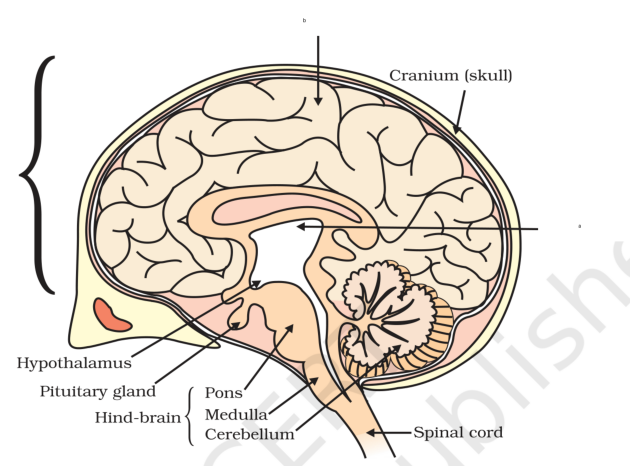

In [21]:

# Main function with single input and auto-exit
def main():
    user_query = input("Enter the prompt: ").strip().lower()


    # Prepend "human" for better query matching
    parsed_query = parse_user_query(user_query)
    print(f"Parsed query: {parsed_query}")
    topic = parsed_query["topic"]
    difficulty = parsed_query["difficulty"]
    num_questions = parsed_query["num_questions"]
    image_path = get_diagram_path(topic, get_info_from_query(topic))

    if image_path:
        generate_questions(topic, num_questions, difficulty, debug_ocr=True)
    else:
        print(f"Image path not found for '{topic}'. Please check the diagram name or metadata.")

if __name__ == "__main__":
    main()

In [19]:
from google.colab import files
import shutil

# Replace 'your_folder_name' with the actual folder name you want to download
folder_name = '/content/dam'
zip_name = f'{folder_name}.zip'

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zipped folder
files.download(zip_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>